In [1]:
# default_exp match_font_optim
%load_ext autoreload
%autoreload 2

# Experiment 1: Optimising to Match an Existing Font

> Using `MatchFontLoss` to optimise the font parameters to match an existing font.

In [2]:
#export
from aifont.core import *
from aifont.fontlearner import *
from aifont.fontsampler import *
from aifont.ocrlearner import *
from collections import OrderedDict
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import gc
from nbdev.showdoc import *
from pandas import DataFrame
from PIL.ImageOps import invert
import pydiffvg
import torch
from typing import Callable, List, Protocol, Tuple, Union

## Font Learner Factory

In [8]:
#export
def get_match_font_learner(seed = 42, 
    font_fn = "Arial.ttf",
    font_size = .8,
    font_y = 24/28 * .8,
    samples=3, # We don't care so much about noise here
    **kwargs
    ) -> VectorLearner:
    gc.collect()
    cb = DebugCB(vocal=False)
    learner = create_font_learner(loss_type=LossType.MATCH_FONT,
                                  match_font_path=SYS_FONT_PATH/font_fn,
                                  match_font_size=font_size,
                                  match_font_y=font_y,
                                  letters=None,
                                  cbs=cb,
                                  folder=None,
                                  n_colors_out=1,
                                  lr=1e-2, 
                                  init_range=2.,
                                  seed=seed,
                                  samples=samples,
                                  **kwargs)
    return learner

In [4]:
#export
def get_learner(seed = 42, 
    version = "aug", 
    use_ocr_tfms = False,
    tfms_p = .5,
    tfms_set = "default",
    **kwargs
    ) -> VectorLearner:
    gc.collect()
    if 'ocr_model' not in locals() or ocr_model is None:
        ocr_model = load_ocr_model(arch=kaggle_cnn_a_with_res, 
                                   df=get_combined_az_and_tmnist_df,
                                   version=version)
    cb = DebugCB(vocal=False)
    ocr_tfms = None
    if use_ocr_tfms:
        # These are the same ones as used for the OCR model
        max_rotate = 15.0
        max_warp = .25
        size = 28
        if   tfms_set == "strong":  blur = GaussianBlur(p=tfms_p, random_size=(5, 9), sigma=10.)
        elif tfms_set == "xstrong": blur = GaussianBlur(p=tfms_p, kernel_size=(9, 9), sigma=10.)
        else:                       blur = GaussianBlur(p=tfms_p, random_size=5)
        noise = Noise(p=tfms_p, f=(0., .6))
        tfms = aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=max_rotate, 
                              min_zoom=0.85, max_zoom=1.15, max_warp=max_warp, p_affine=tfms_p, 
                              p_lighting=0., xtra_tfms=None, size=size, mode='bilinear', 
                              pad_mode='reflection', align_corners=True, batch=False, 
                              min_scale=1.0)
        warp = tfms[0]
        ocr_tfms = [warp, blur]
        if tfms_set == "default": ocr_tfms += noise
    learner = create_font_learner(ocr_tfms=ocr_tfms,
                                letters=None,
                                cbs=cb,
                                folder=None,
                                ocr_model=ocr_model,
                                n_colors_out=1,
                                lr=1e-2, 
                                init_range=2.,
                                seed=seed,
                                **kwargs)
    if use_ocr_tfms: assert len(learner.loss_func.ocr_loss.tfms) == len(ocr_tfms)
    return learner

## Optimisation Utilities

Copied from `05_full_aphabet_optimisation.ipynb`. 

In [5]:
DUMP_FOLDER = "results/test_10_augmented"

class ParamRecorderCB(Callback):
    best: dict = None
    best_on = None
    last_best_loss = None
    results: list[dict] = []
    def __init__(self, 
        max_epochs_after_best: int = None, 
        *args, **kwargs
        ):
        super(ParamRecorderCB, self).__init__(*args, **kwargs)
        store_attr("max_epochs_after_best")
    def before_fit(self):
        self.best_on = 0
        if self.best is None: self.last_best_loss = self.get_current_loss()
    def after_loss(self):
        if not self.training: return
        l  = self.loss.item()
        lr = self.opt.hypers[-1]["lr"]
        p  = self.get_param_dict()
        if not self.best or l < self.best["loss"]:
            self.best = dict(loss=l, lr=l, params=p)
            self.best_on = self.epoch
        elif self.max_epochs_after_best is not None and \
             self.epoch - self.best_on > self.max_epochs_after_best:
            raise CancelFitException()
    def after_fit(self):
        impr = self.last_best_loss - self.best["loss"]
        self.last_best_loss = self.best["loss"]
        impr_fr = impr / (self.last_best_loss + EPS)
        self.results.append(dict(impr=impr, 
                                 impr_fr=impr_fr,
                                 stopped_at=self.epoch,
                                 n_epochs=self.n_epoch,
                                 **self.best))
        print(f"Improvement {impr:.4f} ({impr_fr:.2%})")
    def reset_to_best(self):
        """Reset to the best saved parameters."""
        assert self.best
        self.load_param_dict(self.best["params"])

def fancy_fit_2(
    learner: VectorLearner,
    param_cb: ParamRecorderCB,
    epochs = 100,
    epoch_increment = 0,
    lr = 1e-1,
    lr_factor = .9,
    iters = 40,
    max_zero_iters = 2,
    max_epochs_after_best = 10
    ) -> list[dict]:
    """A fancier fitting algorithm, which tests picks the best epoch after
       fitting, resets to that and adjusts `lr` and `epochs` if needed."""
    old_max = param_cb.max_epochs_after_best
    param_cb.max_epochs_after_best = max_epochs_after_best
    last_zero = None
    for i in range(iters):
        clear()
        print(f"Iteration {i + 1}/{iters} • lr {lr:.4f}")
        learner.fit(epochs, lr)
        res = param_cb.results[-1]
        if res["impr"] <= 0 or res["stopped_at"] < res["n_epochs"] - 1:
            param_cb.reset_to_best()
            if last_zero is None: last_zero = i
            if max_zero_iters is not None and i - last_zero > max_zero_iters: break
            lr        *= lr_factor
            epochs    += epoch_increment
        else: last_zero = None
    clear()
    param_cb.max_epochs_after_best = old_max
    return param_cb.results

def fancy_fit_2_variations(
    filename: str,
    variations = 50,
    dump_folder = DUMP_FOLDER,
    bs = None,
    ocr_version = "aug", 
    use_ocr_tfms = False,
    tfms_p = .5,
    tfms_set = "default",
    **kwargs
    ) -> list[dict]:
    """Create `iters` optimised iterations by reinitialising parameters either randomly
        or from `initial_params` list and training for `epochs` with `lrs`."""
    def noop(*args): pass
    path = os.path.join(dump_folder, filename)
    results = []
    for k in range(variations):
        gc.collect()
        self = get_learner(seed=None, bs=bs, version=ocr_version, use_ocr_tfms=use_ocr_tfms, tfms_p=tfms_p, tfms_set=tfms_set)
        param_cb = ParamRecorderCB()
        self.add_cb(param_cb)
        self.recorder.logger = noop
        self.reset_parameters()
        init_pars = self.get_param_dict()
        init_loss = self.get_current_loss()
        var_res = fancy_fit_2(self, param_cb, **kwargs)
        res = {
            "initial_params": init_pars,
            "final_params":   self.get_param_dict(),
            "init_loss":      init_loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            self.render_letters()
            }
        dump(res, f"{path}{k}.pkl")
        results.append(res)
    dump(results, f"{path}all.pkl")
    return results

def plot_variation_results(
    variations: list[dict],
    figsize = (6, 6),
    lim: float = None
    ) -> None:
    """Plot the results from `fancy_fit_2_variations`."""
    df = DataFrame(variations)
    if lim is None: lim = math.ceil(max(df.init_loss)) 
    init_med, final_med = np.median(df.init_loss), np.median(df.final_loss)
    impr_med = np.median((df.init_loss - df.final_loss) / df.init_loss)
    min_loss = df.final_loss.min()
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    ax.set_xlim(0, lim), ax.set_ylim(0, lim)
    ax.scatter(df.init_loss, df.final_loss)
    ax.scatter(init_med, final_med)
    plt.suptitle(f"Initial losses vs final losses\n(median in orange, median improvement {impr_med:.2%},\nmin loss {min_loss:.4f})")
    plt.xlabel(f"Initial loss"), plt.ylabel(f"Final loss")

def show_variation_renders(
    variations: Union[list[dict], DataFrame],
    n = 12,
    n_cols = 4,
    fig_width = 14,
    incl_tfms = False,
    learner: VectorLearner = None
    ) -> plt.Figure:
    """Show the rendered images together with losses, possibly paired with loss-function-transformed images."""
    if incl_tfms: assert learner is not None, "You must supply a learner if incl_tfms is True"
    if type(variations) is list: variations = DataFrame(variations)
    variations = variations.sort_values(by="final_loss").reset_index()
    n_imgs = n if n is not None and len(variations) > n else len(variations)
    if incl_tfms: n_imgs *= 2
    n_rows = math.ceil(n_imgs / n_cols)
    _img = variations.iloc[0].img
    img_ratio = _img.height / _img.width
    fig_height = (fig_width / n_cols * img_ratio + .5) * n_rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        if i >= n_imgs: break
        is_tfmd = incl_tfms and i % 2 == 1
        v = variations.iloc[i//2 if incl_tfms else i]
        if is_tfmd: img = v.img_with_tfms if "img_with_tfms" in v else \
                          learner.load_param_dict(v.final_params).render_letters(apply_tfms=True)
        else:       img = v.img
        ax.imshow(img)
        ax.set_title("With loss tfms" if is_tfmd else f"Loss {v.final_loss:.4f}")
    title = "Rendered fonts and losses"
    if incl_tfms: title += "\nwith examples of loss-function-transformed images\n(Note that true transforms may be randomised)"
    fig.suptitle(title)
    plt.show()
    return fig

def avg_loss(
    learner,
    n = 20,
    return_list = False
    ) -> float:
    """Calc avg loss over `n` iterations."""
    losses = []
    for i in range(n): losses.append(learner.get_current_loss())
    return losses if return_list else sum(losses) / n

def print_losses(
    losses: Union[list, np.array], 
    msg = None
    ) -> dict:
    """Print basic stats of losses."""
    if msg is not None: msg += ": "
    losses = np.array(losses)
    l_mean = losses.mean()
    l_std = losses.std()
    l_spread = losses.max() - losses.min()
    print(f"{msg}Mean: {l_mean:.4f} • SD: {l_std:.4f} ({l_std / l_mean:.1%}) • Spread {l_spread:.4f} ({l_spread / l_mean:.1%})")
    return(dict(mean=l_mean, std=l_std, spread=l_spread))

def get_individual_losses(
    learner,
    iters = 20
    ) -> np.array:
    """Get losses for individual letters. Mean over `iters`."""
    loss = OCRLoss(ocr_model=load_ocr_model(arch=kaggle_cnn_a_with_res, df=get_combined_az_and_tmnist_df),
                   tfms=learner.loss_func.ocr_loss.tfms, reduction='none')
    b = L(learner.dls.train)[0]
    x, y = b
    losses = {k.item(): [] for k in y}
    for i in range(iters):
        v = learner.model(x)
        ll = loss(v, y)
        for k, l in zip(y, ll[0]): losses[k.item()].append(l.item())
    losses_list = [losses[k] if k in losses else [-1.] for k in range(len(learner.vocab))]
    means = [np.array(l).mean() for l in losses_list]
    return np.array(means)

def plot_current_individual_losses(
    learner,
    **kwargs
    ) -> np.array:
    means = get_individual_losses(learner, **kwargs)
    letters = learner.vocab
    fig = plt.figure()
    ax = fig.add_subplot()
    line, = ax.plot(means)
    ax.set_xticks(range(len(letters)), labels=letters)
    return means

def try_params(
    learner,
    param = "Width, HNU",
    steps = 40,
    min = -4., max = 4., 
    loss_iters = 20
    ) -> DataFrame:
    """Try different param values and record individual letters losses (mean overs `loss_iters`)."""
    assert steps > 1
    self = learner
    lf = self.loss_func
    with debug(lf):
        model = self.model
        stats = []
        for i in range(steps):
            report("Trying params", prog = i / steps)
            v = min + (max - min) * i / (steps - 1)
            model.set_param(param, v)
            means = {f"loss_{k}": v for k, v in zip(learner.vocab, get_individual_losses(learner, iters=loss_iters))}
            d = {
                "value": model.get_param(param).item(), # There's a discrepancy between v and this
                "interpolated_value": model.get_param_value(param).item(),
                **means
                }
            stats.append(d)
    return DataFrame(stats)

def create_or_load_variations(fn: str,
    plot = True,
    **fancy_fit_args
    ) -> list[dict]:
    """Shortcut for `fancy_fit_2_variations` that saves the results. If there 
       already are results saved with `fn`, loads them instead."""
    fp = os.path.join(DUMP_FOLDER, fn)
    try: res = load(fp)
    except: 
        res = fancy_fit_2_variations(**fancy_fit_args, filename=fn)
        dump(res, fp)
    if plot: plot_variation_results(res, lim=4)
    return res

def apply_best_params(learner,
    variations: list
    ) -> VectorLearner:
    "Apply the params with the lowest loss from variations to learner."
    best = sorted(variations, key=lambda x: x["final_loss"])[0]
    learner.load_param_dict(best["final_params"])
    return learner

def fancy_fit_3_variations_match_font(
    filename: str,
    variations = 50,
    dump_folder = DUMP_FOLDER,
    zero_width = True,
    **kwargs
    ) -> list[dict]:
    """Create `iters` optimised iterations by reinitialising parameters either randomly
        or from `initial_params` list and training for `epochs` with `lrs`."""
    path = os.path.join(dump_folder, filename)
    results = []
    for k in range(variations):
        gc.collect()
        self = get_match_font_learner()
        self.reset_parameters()
        if zero_width:
            for p in self.param_names:
                if p.startswith("Width"): self.set_param(p, 0.)
        init_pars = self.get_param_dict()
        init_loss = self.get_current_loss()
        with self.no_progress(): var_res = fancy_fit_3(self, msg=f"Variation {k + 1}/{variations} • ", **kwargs)
        res = {
            "initial_params": init_pars,
            "final_params":   var_res[-1]["params"],
            "init_loss":      init_loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            self.render_letters(),
            }
        dump(res, f"{path}{k}.pkl")
        results.append(res)
    dump(results, f"{path}all.pkl")
    return results

def fancy_fit_3_match_font(learner: VectorLearner,
    epochs = 40,
    epoch_increment = 0,
    lr = 1e-1,
    lr_factor = .9,
    iters = 20,
    abort_if = 0.75,
    abort_at = 2,
    msg = ""
    ) -> list[dict]:
    """Perform multiple fitting sessions."""
    res = []
    orig_loss = learner.get_current_loss()
    for i in range(iters):
        report(f"{msg}Iteration {i + 1}/{iters} • lr {lr:.4f}")
        learner.fit(epochs, lr)
        l = learner.get_current_loss()
        res.append(dict(lr=lr,
                        loss=l,
                        params=learner.get_param_dict() ))
        if i >= abort_at and l > abort_if * orig_loss: break
        lr *= lr_factor
        epochs += epoch_increment
    clear()
    return res

def fancy_fit_4_variations(
    filename: str,
    variations = 20,
    dump_folder = DUMP_FOLDER,
    bs = None,
    version = "aug", 
    use_ocr_tfms = False,
    tfms_p = .5,
    tfms_set = "default",
    zero_width = False,
    **kwargs
    ) -> list[dict]:
    """Create `iters` optimised iterations by reinitialising parameters either randomly
        or from `initial_params` list and training for `epochs` with `lrs`."""
    path = os.path.join(dump_folder, filename)
    results = []
    for k in range(variations):
        gc.collect()
        self = get_learner(seed=None, bs=bs, version=version, use_ocr_tfms=use_ocr_tfms, tfms_p=tfms_p, tfms_set=tfms_set)
        self.reset_parameters()
        if zero_width:
            for p in self.param_names:
                if p.startswith("Width"): self.set_param(p, 0.)
        init_pars = self.get_param_dict()
        init_loss = self.get_current_loss()
        with self.no_progress(): var_res = fancy_fit_4(self, msg=f"Variation {k + 1}/{variations} • ", **kwargs)
        res = {
            "initial_params": init_pars,
            "final_params":   var_res[-1]["params"],
            "init_loss":      init_loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            self.render_letters(),
            "img_with_tfms":  self.render_letters(apply_tfms=True)
            }
        dump(res, f"{path}{k}.pkl")
        results.append(res)
    dump(results, f"{path}all.pkl")
    return results

def fancy_fit_4(learner: VectorLearner,
    epochs = 80, # 40
    epoch_increment = 0,
    lr = 1e-1,
    lr_factor = .9,
    iters = 3, # 20
    abort_if = 0.75,
    abort_at = 1, # 2
    max_init_loss = 2., # N/A
    max_reinits = 100,  # N/A
    msg = ""
    ) -> list[dict]:
    """Perform multiple fitting sessions."""
    res = []
    orig_loss = learner.get_current_loss()
    if max_init_loss is not None:
        j = 0
        while orig_loss > max_init_loss:
            if j >= max_reinits: return [dict(lr=lr,
                                              loss=orig_loss,
                                              params=learner.get_param_dict(),
                                              note="Max reinits exceeded")]
            j += 1
            learner.reset_parameters()
            orig_loss = learner.get_current_loss()
    for i in range(iters):
        report(f"{msg}Iteration {i + 1}/{iters} • lr {lr:.4f}")
        learner.fit(epochs, lr)
        l = learner.get_current_loss()
        res.append(dict(lr=lr,
                        loss=l,
                        params=learner.get_param_dict()))
        if i >= abort_at and l > abort_if * orig_loss: break
        lr *= lr_factor
        epochs += epoch_increment
    clear()
    return res

## Other Utilities

In [10]:
def get_learner_for_fit_letters(calc_loss = False
    ) -> Union[VectorLearner, Tuple[float, VectorLearner]]:
    "Shortcut for getting a learner for tests in this experiment."
    gc.collect()
    learner_args = dict(version = "aug", 
                        use_ocr_tfms = True,
                        tfms_p = 1.,
                        tfms_set = "xstrong",
                        bs = 4 * len(VOCAB_UC))
    learner = get_learner(seed = 42, **learner_args)
    fn_exp5 = "variations_exp5_xstrong_aug"
    fp_exp5 = os.path.join(DUMP_FOLDER, fn_exp5)
    res_exp5 = load(fp_exp5)
    apply_best_params(learner, res_exp5)
    if calc_loss:
        init_loss = learner.get_current_loss(iters=10)
        print(f"Init loss: {init_loss}")
        return init_loss, learner
    else: return learner

def get_font_ocr_loss(
    learner: VectorLearner,
    fn: str = "Arial.ttf",
    folder: Path = SYS_FONT_PATH,
    size_range = (0.5, 1.0),
    steps = 20
    ) -> List[dict]:
    """Find the optimal size for the font and display the OCR loss for that."""
    assert steps > 1
    font_path = folder/fn
    vocab = learner.vocab
    m = learner.model
    w,h = m.canvas_width,m.canvas_height
    lf = learner.loss_func.ocr_loss
    with eval_model(m): x,y = list(learner.dls.train)[0]
    res = []
    sizes = set([round(h * (size_range[0] + i * (size_range[1] - size_range[0]) / (steps - 1))) for i in range(steps)])
    for size in sizes:
        imgs = []
        for x_i in x:
            l = vocab[x_i]
            imgs.append(render_text(font_path, text=l, text_size=size, image_width=w, image_height=h, as_normalised_array=True))
        img_t = concat_tensors(imgs).reshape(-1, 1, w, h)
        loss = lf(img_t, y).item()
        res.append(dict(size=size, loss=loss, imgs=imgs, imgs_tfmd=lf.apply_tfms(img_t)))
    res.sort(key=lambda x: x["loss"])
    print(f"Best loss for {fn}: {res[0]['loss']:.4f} at size {res[0]['size']:d}")
    return res

def show_renders_and_target(learner: VectorLearner,
    scale = .5
    ) -> None:
    """Show rendered letters and target letters."""
    pred = learner.render_letters(scale=scale)
    targ = image_grid(learner.loss_func.target_letters, scale=scale).convert('L')
    size = targ.size
    targ2 = Image.new('RGB', size=size, color="white")
    targ2.paste((255,0,0), mask=invert(targ))
    mask = Image.new('L', size=size, color=128)
    comp = Image.composite(pred, targ2, mask)
    grid_size = (3 * size[0], size[1])
    grid = Image.new('RGB', size=grid_size, color="white")
    for i,img in enumerate([comp, pred, targ]): grid.paste(img, box=(i * size[0], 0))
    print(f"Loss: {learner.get_current_loss()}")
    display(grid)

def plot_variation_losses(variations: list[dict],
    figsize = (10, 10),
    y_range: Tuple[float, float] = None
    ) -> None:
    """Plot the loss trajectories from `fancy_fit_2/3_variations`."""
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    if y_range: ax.set_ylim(*y_range)
    for v in variations:
        res = v["full_res"]
        losses = [v["init_loss"]] + [o["loss"] for o in res]
        ax.plot(range(len(res) + 1), losses)
    plt.xticks(range(1 + max([len(v["full_res"]) for v in variations])))
    plt.xlabel(f"Iterations completed")
    plt.ylabel(f"Loss")

## 5. Interlude: Check Fitting Convergence Statistics

Load the results from the previous augmented fitting sessions to see how many iterations and epochs are actually necessary for convergence. It also strongly looks like we should discard any attempts where the initial loss is much above 1.5. Another possibility is to start with an even higher learning rate so as not to get stuck in the initial neighbourhood.

The parameters that were used for the results analysed below are:

    epochs = 40,
    epoch_increment = 0,
    lr = 1e-1,
    lr_factor = .9,
    iters = 20,
    abort_if = 0.75,
    abort_at = 2,

In [15]:
fn_exp5 = "variations_exp5_xstrong_aug"
fp_exp5 = os.path.join(DUMP_FOLDER, fn_exp5)
res_exp5 = load(fp_exp5)

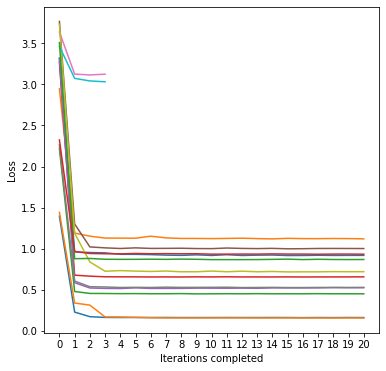

In [24]:
plot_variation_losses(res_exp5, figsize=(6,6))

> It seems that no more than 3 iterations are needed. Maybe we should add some epochs to iterations instead.

## 4. Test: Freezing Some Parameters and Optimising With Augmentation

For the final experiment, we'll start from a font model that's optimised for Arial, freeze a subset of the parameters and optimise the rest with augmented `OCRLoss`.

> See Experiment 3 (nb 17) for a proper attempt at this. 

In [7]:
frozen_params = [
    "Height",
    # "Midline",
    # "Stroke width",
    # "Bowl curvature",
    "Width, AV",
    "Width, BPR",
    "Width, D",
    "Width, EF",
    "Width, CGOQ",
    "Width, HNU",
    "Width, J",
    "Width, K",
    "Width, L",
    "Width, M",
    "Width, S",
    "Width, TZ",
    "Width, W",
    "Width, XY",
    "Width n difference from O, C",
    "Width n difference from E, F",
    "Width n difference from O, G",
    # "Offset x from symmetry, AXZ",
    "Overshoot, AMNVW",
    "Overshoot, CGJOSQ",
    "Crossbar y offset, A",
    "Crossbar y offset, B",
    "Crossbar y offset, G",
    "Crossbar y offset, P",
    "Crossbar y offset, R",
    "Crotch y offset, Y",
    # "Crossbar length, G",
    # "Bar stem height, G",
    # "Bowl aspect ratio, BPR",
    # "Bowl aspect ratio, BPR",
    # "Bowl aspect ratio, D",
    # "Bowl aspect ratio, J",
    # "Bowl aspect ratio, U",
    # "Bowl distortion, BPR",
    # "Bowl distortion, J",
    # "Upper bowl xn offset, B",
    # "Upper width n difference, E",
    # "Upper bowl ratio to lower, S",
    # "Upper bowl xp offset, S",
    # "Upper width n difference, X",
    # "Upper width n difference, Z",
    "Middle width n difference, E",
    "Middle width n difference, F",
    # "Aperture, CGS",
    # "Aperture, J",
    "Arm xn offset, K",
    "Stem-arm connection height, K",
    # "Arm-leg connection location, K",
    "Stem xp offset from vertical, M",
    # "Tail angle, Q",
    # "Tail length, Q",
    # "Tail-bowl connection location, Q",
    # "Tail inside fraction, Q",
    # "Leg xp offset, R",
    # "Leg-bowl connection location, R",
    # "Leg distortion, R",
    ]

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2548: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:615: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


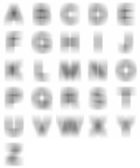

In [8]:
learner_args = dict(version = "aug", 
                    use_ocr_tfms = True,
                    tfms_p = 1.,
                    tfms_set = "xstrong",
                    bs = 4 * len(VOCAB_UC))
learner = get_learner(seed=42, **learner_args)
init_params = load(f"{DUMP_FOLDER}/match_font_Arial_final")
learner.load_param_dict(init_params)
learner.freeze_params(frozen_params)
learner.render_letters(apply_tfms=True)

In [9]:
exp3_res = fancy_fit_3_match_font(learner)

epoch,train_loss,valid_loss,time
0,30.762503,30.128832,00:07
1,30.443789,29.526659,00:07
2,30.132099,29.059000,00:07
3,29.855724,28.611879,00:07
4,29.596836,28.164808,00:07
5,29.345829,27.722897,00:07
6,29.100010,27.294922,00:07
7,28.858042,26.872868,00:07
8,28.620054,26.457876,00:07
9,28.383200,26.042294,00:07


epoch,train_loss,valid_loss,time
0,17.010683,16.922806,00:07
1,16.966694,16.833241,00:07
2,16.921108,16.741550,00:07
3,16.873871,16.651945,00:07
4,16.828079,16.558096,00:07
5,16.780788,16.471703,00:07
6,16.733791,16.377296,00:07
7,16.686222,16.290514,00:07
8,16.638248,16.198671,00:07
9,16.590023,16.109114,00:07


epoch,train_loss,valid_loss,time
0,13.403337,13.318754,00:08
1,13.361790,13.234045,00:07
2,13.318482,13.154003,00:07
3,13.276665,13.077674,00:07
4,13.234869,12.995541,00:07
5,13.192706,12.911280,00:07
6,13.149950,12.826039,00:07
7,13.106662,12.747793,00:07
8,13.063560,12.669222,00:07
9,13.020073,12.586353,00:07


epoch,train_loss,valid_loss,time
0,10.905769,10.903078,00:07
1,10.904984,10.903240,00:06
2,10.904784,10.912455,00:07
3,10.905956,10.905500,00:07
4,10.905420,10.904461,00:07
5,10.905657,10.903822,00:07
6,10.905102,10.910206,00:07
7,10.905511,10.902826,00:07
8,10.905580,10.924718,00:07
9,10.907661,10.909863,00:07


epoch,train_loss,valid_loss,time
0,10.902544,10.900360,00:07
1,10.902173,10.899906,00:07
2,10.901080,10.893656,00:07
3,10.900347,10.895004,00:07
4,10.899645,10.898213,00:07
5,10.899221,10.893526,00:07
6,10.898793,10.898446,00:07
7,10.898541,10.897049,00:07
8,10.898201,10.898749,00:07
9,10.898057,10.896469,00:07


epoch,train_loss,valid_loss,time
0,10.896135,10.893071,00:07
1,10.894735,10.894250,00:07
2,10.894604,10.894469,00:07
3,10.893982,10.895693,00:07
4,10.894466,10.898482,00:07
5,10.894925,10.895726,00:07
6,10.894566,10.891483,00:07
7,10.894245,10.898021,00:07
8,10.894726,10.894115,00:07
9,10.894789,10.891114,00:07


epoch,train_loss,valid_loss,time
0,10.893232,10.891866,00:07
1,10.892981,10.890693,00:07
2,10.893140,10.890891,00:07
3,10.892583,10.891638,00:07
4,10.892156,10.891516,00:07
5,10.892258,10.901866,00:07
6,10.893830,10.889985,00:07
7,10.893728,10.893437,00:07
8,10.893724,10.891656,00:07
9,10.893573,10.892324,00:07


epoch,train_loss,valid_loss,time
0,10.895372,10.891325,00:07
1,10.894209,10.889065,00:07
2,10.892615,10.891247,00:07
3,10.892288,10.894300,00:07
4,10.892407,10.893158,00:07
5,10.892421,10.893461,00:07
6,10.892879,10.891830,00:07
7,10.892560,10.889777,00:07
8,10.892625,10.893989,00:07
9,10.892770,10.890508,00:07


epoch,train_loss,valid_loss,time
0,10.898414,10.892630,00:07
1,10.894285,10.890995,00:07
2,10.893993,10.891454,00:07
3,10.892723,10.894996,00:07
4,10.893235,10.890647,00:07
5,10.892644,10.891100,00:07
6,10.892690,10.891100,00:07
7,10.892456,10.891780,00:07
8,10.892498,10.891313,00:07
9,10.892225,10.893310,00:07


epoch,train_loss,valid_loss,time
0,10.890907,10.892959,00:07
1,10.892068,10.888475,00:07
2,10.891429,10.894344,00:07
3,10.891342,10.890614,00:07
4,10.891064,10.889322,00:07
5,10.890847,10.890966,00:07
6,10.891026,10.897531,00:07
7,10.892148,10.890047,00:07
8,10.892396,10.900187,00:07
9,10.892954,10.888594,00:07


epoch,train_loss,valid_loss,time
0,10.888436,10.891671,00:07
1,10.889713,10.892513,00:07
2,10.890019,10.893251,00:07
3,10.889936,10.892038,00:07
4,10.890321,10.889441,00:07
5,10.890683,10.892513,00:07
6,10.890998,10.891587,00:07
7,10.891055,10.897986,00:07
8,10.892011,10.915399,00:07
9,10.894673,10.888308,00:07


epoch,train_loss,valid_loss,time
0,10.891240,10.889777,00:07
1,10.891084,10.893269,00:07
2,10.892230,10.897605,00:07
3,10.893356,10.889082,00:07
4,10.892500,10.887512,00:07
5,10.892023,10.892282,00:07
6,10.891835,10.891856,00:07
7,10.891638,10.887685,00:07
8,10.891217,10.889617,00:07
9,10.891418,10.891280,00:07


epoch,train_loss,valid_loss,time
0,10.900217,10.888184,00:07
1,10.894797,10.892670,00:07
2,10.893184,10.888201,00:07
3,10.892014,10.889848,00:07
4,10.891960,10.890366,00:07
5,10.891828,10.888829,00:07
6,10.891775,10.892576,00:07
7,10.891770,10.891727,00:07
8,10.891654,10.891079,00:07
9,10.891353,10.889174,00:07


epoch,train_loss,valid_loss,time
0,10.889785,10.891097,00:07
1,10.888585,10.887846,00:07
2,10.889254,10.890426,00:07
3,10.889056,10.890010,00:07
4,10.889010,10.889811,00:07
5,10.889379,10.890745,00:07
6,10.889729,10.888986,00:07
7,10.889711,10.893431,00:07
8,10.889989,10.890924,00:07
9,10.890033,10.892694,00:07


epoch,train_loss,valid_loss,time
0,10.894169,10.892994,00:07
1,10.894275,10.891926,00:07
2,10.892068,10.890731,00:07
3,10.892082,10.892695,00:07
4,10.892711,10.889416,00:07
5,10.891783,10.893058,00:07
6,10.891988,10.891128,00:07
7,10.892006,10.889662,00:07
8,10.891829,10.889256,00:07
9,10.891738,10.891428,00:07


epoch,train_loss,valid_loss,time
0,10.890265,10.889692,00:07
1,10.890985,10.888983,00:07
2,10.889727,10.888353,00:07
3,10.889525,10.888137,00:07
4,10.889587,10.890181,00:07
5,10.889277,10.891054,00:07
6,10.889491,10.888526,00:07
7,10.889277,10.887366,00:07
8,10.889284,10.891770,00:07
9,10.889398,10.889794,00:07


epoch,train_loss,valid_loss,time
0,10.893151,10.891961,00:07
1,10.892165,10.892176,00:07
2,10.892275,10.889536,00:07
3,10.891060,10.889193,00:07
4,10.890902,10.888215,00:07
5,10.890605,10.889311,00:07
6,10.890458,10.889762,00:07
7,10.890278,10.887791,00:07
8,10.890204,10.887383,00:07
9,10.890135,10.889655,00:07


epoch,train_loss,valid_loss,time
0,10.891475,10.889406,00:07
1,10.889942,10.888777,00:07
2,10.889596,10.899831,00:07
3,10.892047,10.890192,00:07
4,10.891335,10.887977,00:07
5,10.890973,10.890944,00:07
6,10.890959,10.890512,00:07
7,10.890716,10.890189,00:07
8,10.890450,10.893373,00:07
9,10.890688,10.891455,00:07


epoch,train_loss,valid_loss,time
0,10.888998,10.890743,00:07
1,10.889696,10.888422,00:07
2,10.889340,10.888355,00:07
3,10.889553,10.891749,00:07
4,10.889146,10.888836,00:07
5,10.888897,10.891001,00:07
6,10.889108,10.890983,00:07
7,10.889618,10.894601,00:07
8,10.890060,10.890345,00:07
9,10.889874,10.889441,00:07


epoch,train_loss,valid_loss,time
0,10.887381,10.891558,00:07
1,10.887650,10.887300,00:07
2,10.888545,10.888133,00:07
3,10.888771,10.888052,00:07
4,10.889145,10.890100,00:07
5,10.889255,10.888960,00:07
6,10.889162,10.887797,00:07
7,10.889434,10.890881,00:07
8,10.889484,10.886827,00:07
9,10.889368,10.891773,00:07


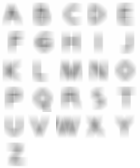

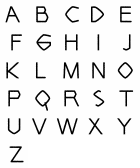

In [11]:
display(learner.render_letters(apply_tfms=True))
display(learner.render_letters())

## 3. Experiment 1b: Optimising to Match Times New Roman

Let's try to optimise to match a drastically different font.

/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2548: UserWarning: Using default input_shape: (128, 128)
  warn(f"Using default input_shape: {input_shape}")


Loss: 0.24510742723941803


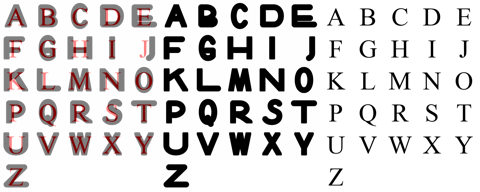

In [18]:
learner = get_match_font_learner(font_fn="Times New Roman.ttf",
                                 mom=.1, 
                                 sqr_mom=.2)
# learner.load_param_dict(load(f"{DUMP_FOLDER}/match_font_TNR_final"))
show_renders_and_target(learner, grid_scale=.25)

In [19]:
lr = 5e-2
# learner.fit(200, lr)

epoch,train_loss,valid_loss,time
0,0.245086,0.232618,00:05
1,0.238790,0.219525,00:05
2,0.232255,0.206449,00:05
3,0.225608,0.195043,00:05
4,0.219241,0.183652,00:04
5,0.213012,0.172827,00:05
6,0.206923,0.162609,00:05
7,0.200983,0.152918,00:04
8,0.195208,0.142996,00:05
9,0.189495,0.133978,00:04


0.03155898302793503
Loss: 0.03158329799771309


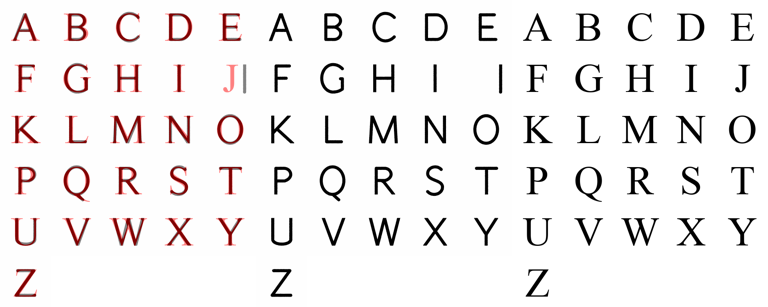

In [22]:
show_renders_and_target(learner, grid_scale=.4)
# dump(learner.get_param_dict(), f"{DUMP_FOLDER}/match_font_TNR_1")

The letter J is stuck in a false optimum. Merely reseting its parameters is not enough to set the optimiser on the right path, so we need to fine-tune some of the parameters as well.

In [32]:
learner.show_params(letters="J")

  11 Width, J                          0.67 ( 0.99)
  35 Bowl aspect ratio, J              1.03 ( 1.47)
  38 Bowl distortion, J                0.00 ( 0.20)
  48 Aperture, J                       2.81 ( 0.95)
  70 Offset x, J                       0.87 ( 0.04)


In [30]:
# learner.load_param_dict(load(f"{DUMP_FOLDER}/match_font_TNR_1"))
# for p in learner.param_names:
#     if param_affects(p, "J", incl_general=False): learner.set_param(p, 0.)
# learner.fit_letters("J", lr=1e-1, n_epoch=30)

epoch,train_loss,valid_loss,time
0,0.083879,0.034619,00:05
1,0.083095,0.034335,00:05
2,0.082885,0.033805,00:04
3,0.082505,0.033386,00:05
4,0.082234,0.032916,00:04
5,0.081922,0.032493,00:04
6,0.081536,0.032321,00:04
7,0.081265,0.032038,00:04
8,0.080993,0.031842,00:04
9,0.080822,0.031677,00:04


Loss: 0.03159809112548828


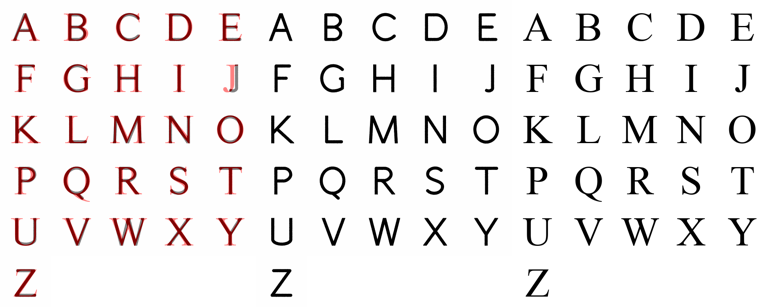

In [34]:
# learner.set_param("Width, J", -1.)
# learner.set_param("Aperture, J", -1.)
show_renders_and_target(learner, grid_scale=.4)

In [37]:
# learner.fit_letters("J", lr=8e-2, n_epoch=20)

epoch,train_loss,valid_loss,time
0,0.053006,0.030771,00:05
1,0.049286,0.030523,00:04
2,0.045314,0.030197,00:04
3,0.041154,0.029977,00:04
4,0.037183,0.029842,00:04
5,0.033878,0.029805,00:04
6,0.031351,0.029881,00:04
7,0.029596,0.029861,00:04
8,0.028110,0.029959,00:04
9,0.027046,0.029902,00:04


Loss: 0.030045317485928535


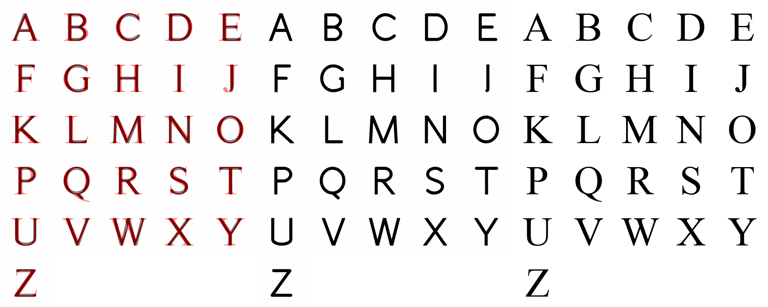

In [39]:
show_renders_and_target(learner, grid_scale=.4)
# dump(learner.get_param_dict(), f"{DUMP_FOLDER}/match_font_TNR_final")

Rerender in higher dpi.

/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2829: UserWarning: Using default input_shape: (128, 128)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2409: UserWarning: Model param specs have a max height of 0.800000011920929 but font_size to match is 0.8!
  warn(f"Model param specs have a max height of {ps['Height'].max.item()} but font_size to match is {font_size}!")


Params in b but not in a: Slant • Params in a but not in b: 
Loss: 0.39951440691947937


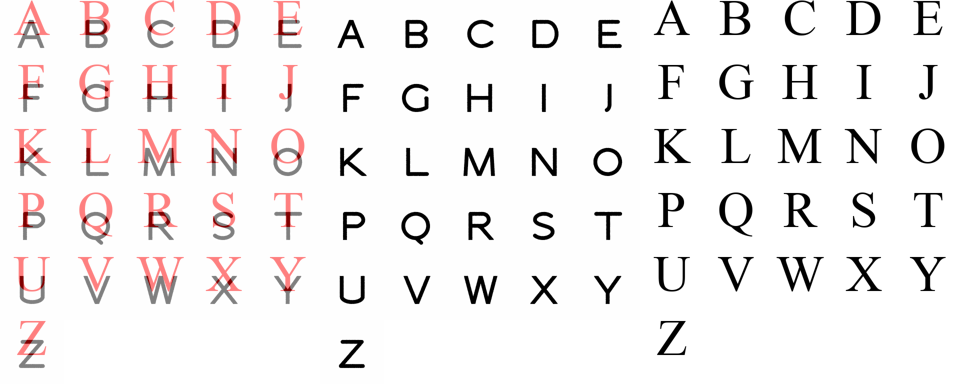

In [12]:
learner = get_match_font_learner(font_fn="Times New Roman.ttf",
                                 mom=.1, 
                                 sqr_mom=.2)
learner.load_param_dict(load(f"{DUMP_FOLDER}/match_font_TNR_final.pkl"))
learner.show_renders_and_target()

## 2. Experiment 1a: Optimising to Match an Existing Font

We've already performed a few rounds of optimization on this model alongside making tweaks in the parameters and vector construction minutiae.

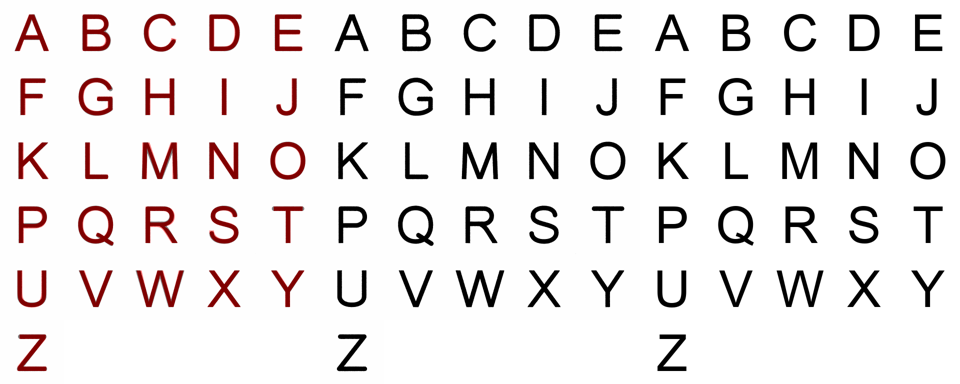

In [12]:
learner = get_match_font_learner(mom=.1, sqr_mom=.2)
# for o in learner.param_names: learner.set_param(o, 0.)
last_params = load(f"{DUMP_FOLDER}/match_font_Arial_final")
learner.load_param_dict(last_params)
show_renders_and_target(learner)

In [13]:
# 50@5e-2; 50@5e-2
lr = 5e-2
# learner.fit(50, lr)
# learner.fit(50, lr)
# learner.fit(150, lr)
# learner.fit(100, 1e-1)
# learner.fit_letters("DJU", lr=5e-2, n_epoch=50)
# learner.fit(50, lr)
# learner.fit(100, lr)
# learner.fit(100, lr)
# learner.fit(30, 2e-2)

epoch,train_loss,valid_loss,time
0,0.007705,0.004772,00:05
1,0.006221,0.004826,00:05
2,0.005752,0.005158,00:05
3,0.005596,0.004793,00:05
4,0.005433,0.004568,00:05
5,0.005276,0.004770,00:06
6,0.005202,0.004609,00:06
7,0.005124,0.004608,00:06
8,0.005063,0.004594,00:05
9,0.005010,0.004675,00:05


Loss: 0.004577071405947208


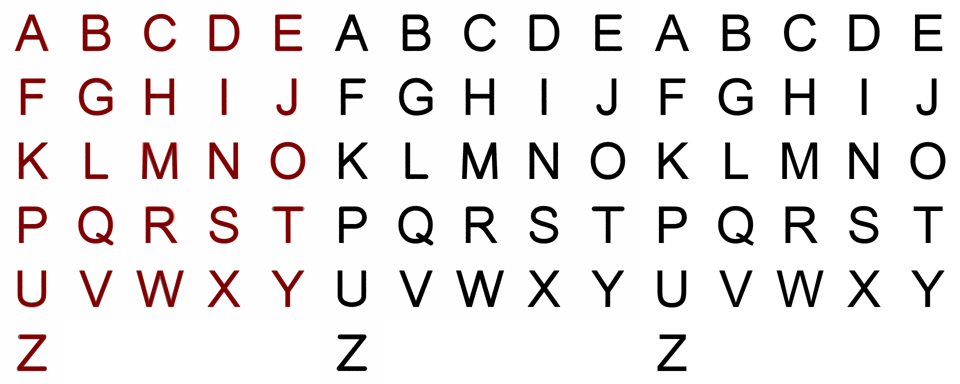

In [17]:
# dump(learner.get_param_dict(), f"{DUMP_FOLDER}/match_font_Arial_final")
show_renders_and_target(learner)

## 1. Interlude: Check That Canvas-Resizing Works

We need to ensure that canvas-resizing works so that we can use a higher resolution later on for font matching.

In [15]:
learner = get_learner_for_fit_letters()

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2475: UserWarning: Using default input_shape: (28, 28)
  def get_dl(): return LetterDL.from_vocab(vocab, epoch_len=epoch_len, bs=bs) if letters is None else \
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:603: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


The two renderings below should match (with the exception of aliasing)


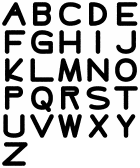

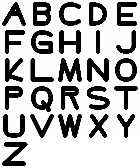

In [16]:
scale = 5
old_size = 28
new_size = old_size * scale
print("The two renderings below should match (with the exception of aliasing)")
display(learner.render_letters())
learner.model.canvas_height = learner.model.canvas_width = new_size
display(learner.render_letters(scale=1/scale))
learner = None; gc.collect(); ""

## Export

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted 02_ocrlearner.ipynb.
Converted 03_fontlearner.ipynb.
Converted index.ipynb.
